TP 4 : RÉGULARISATION ET ALGORITHMES PROXIMAUX

        — Comprendre l’effet de la norme L1 sur la sélection de variables.
        — Implémenter l’opérateur proximal de la norme L1 (Soft-Thresholding).
        — Programmer l’algorithme ISTA (Iterative Soft-Thresholding Algorithm).
        — Comparer les solutions du Lasso (L1) et de Ridge (L2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LogisticRegression

PARTIE 1 : OPERATEUR DE SEUILLAGE DOUX 

In [3]:
def soft_thresholding(v, gamma):
    return np.sign(v) * np.maximum(0, np.abs(v) - gamma)


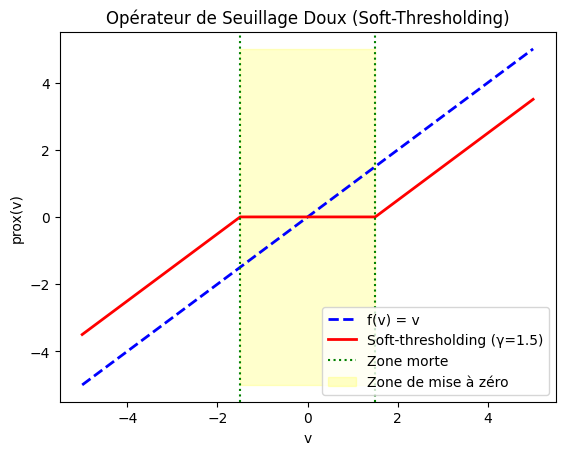

In [ ]:
v_range = np.linspace(-5, 5, 1000)
gamma = 1.5
v_thresholded = soft_thresholding(v_range, gamma)

plt.plot(v_range, v_range, 'b--', label='f(v) = v', linewidth=2)
plt.plot(v_range, v_thresholded, 'r-', label=f'Soft-thresholding (γ={gamma})', linewidth=2)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=-gamma, color='g', linestyle=':', label='Zone morte', linewidth=1.5)
plt.axvline(x=gamma, color='g', linestyle=':', linewidth=1.5)
plt.fill_between(v_range, -5, 5, where=(np.abs(v_range) <= gamma), 
                 alpha=0.2, color='yellow', label='Zone de mise à zéro')
plt.xlabel('v')
plt.ylabel('prox(v)')
plt.title('Opérateur de Seuillage Doux (Soft-Thresholding)')
plt.legend()
#plt.grid(True, alpha=0.3)
plt.savefig('soft_thresholding.png')

PARTIE 2 : ALGORITHME ISTA

In [7]:
np.random.seed(42)
n = 100  # nbre d'echantillons
d = 50   # nbre de caracteristiques
k = 5    # nbre de variables explicatives

In [ ]:
#vecteur poids (creux)
w_creux = np.zeros(d)
indices_actifs = np.random.choice(d, k, replace=False)
w_creux[indices_actifs] = np.random.randn(k) * 3

#X et y
X = np.random.randn(n, d)
y = X @ w_creux + np.random.randn(n) * 0.5

print(f"Dataset généré: n={n}, d={d}")
print(f"Nombre de variables vraiment actives: {k}")
print(f"Indices des variables actives: {sorted(indices_actifs.tolist())}")



 Dataset généré: n=100, d=50
 Nombre de variables vraiment actives: 5
 Indices des variables actives: [4, 6, 15, 16, 25]


In [11]:
val_prop = np.linalg.eigvalsh(X.T @ X)
L = np.max(val_prop) / n
print(f"\n Constante de Lipschitz L = {L:.4f}")


 Constante de Lipschitz L = 2.7437


In [12]:
def ista(X, y, lambda_reg, max_iter=1000, tol=1e-6):
    n, d = X.shape
    w = np.zeros(d)
    
    #constante de Lipschitz
    val_prop = np.linalg.eigvalsh(X.T @ X)
    L = np.max(val_prop) / n
    step_size = 1.0 / L
    
    objectives = []
    
    for i in range(max_iter):
        #fonction objectif
        residual = X @ w - y
        obj = 0.5 / n * np.sum(residual**2) + lambda_reg * np.sum(np.abs(w))
        objectives.append(obj)
        
        # Gradient de la partie lisse
        gradient = (X.T @ residual) / n
        
        # Pas de gradient
        w_temp = w - step_size * gradient
        
        # Pas proximal (soft-thresholding)
        w_new = soft_thresholding(w_temp, lambda_reg * step_size)
        
        # Test de convergence
        if np.linalg.norm(w_new - w) < tol:
            print(f"Convergence atteinte à l'itération {i}")
            w = w_new
            break
        
        w = w_new
    
    return w, np.array(objectives)

Convergence atteinte à l'itération 46

ISTA terminé
Nombre de coefficients non nuls: 7
Indices des coefficients non nuls: [ 2  4  6 15 16 25 33]


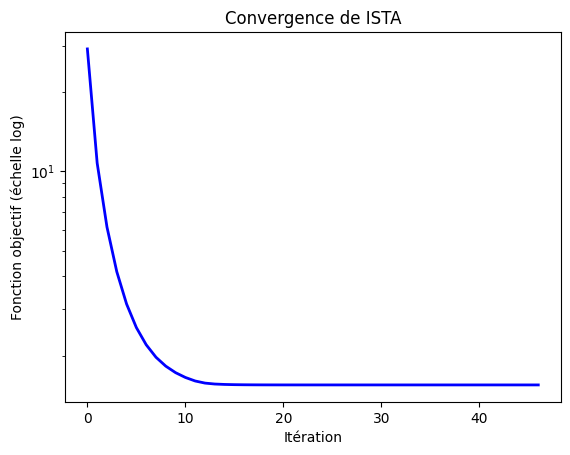

In [13]:
lambda_reg = 0.1
w_ista, objectives_ista = ista(X, y, lambda_reg)

print(f"\nISTA terminé")
print(f"Nombre de coefficients non nuls: {np.sum(np.abs(w_ista) > 1e-6)}")
print(f"Indices des coefficients non nuls: {np.where(np.abs(w_ista) > 1e-6)[0]}")

plt.semilogy(objectives_ista, 'b-', linewidth=2)
plt.xlabel('Itération')
plt.ylabel('Fonction objectif (échelle log)')
plt.title('Convergence de ISTA')
plt.savefig('ista_convergence.png')

PARTIE 3 : ANALYSE DE LA PARCIMONIE

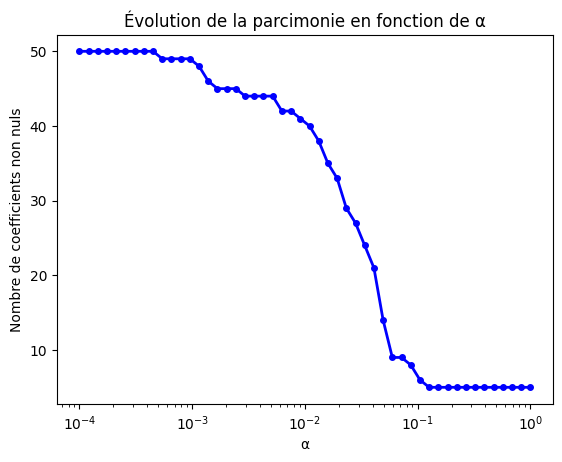

In [17]:
alphas = np.logspace(-4, 0, 50)
coefficients = []
n_nonzero = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X, y)
    coefficients.append(lasso.coef_)
    n_nonzero.append(np.sum(np.abs(lasso.coef_) > 1e-6))

coefficients = np.array(coefficients)

#coeffs non nuls

plt.semilogx(alphas, n_nonzero, 'bo-', linewidth=2, markersize=4)
plt.xlabel('α')
plt.ylabel('Nombre de coefficients non nuls')
plt.title('Évolution de la parcimonie en fonction de α')
plt.savefig('sparsity_evolution.png')


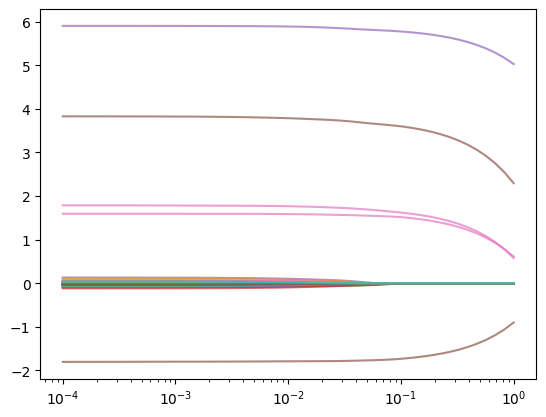

In [18]:
for i in range(d):
    plt.semilogx(alphas, coefficients[:, i], linewidth=1.5, alpha=0.7)

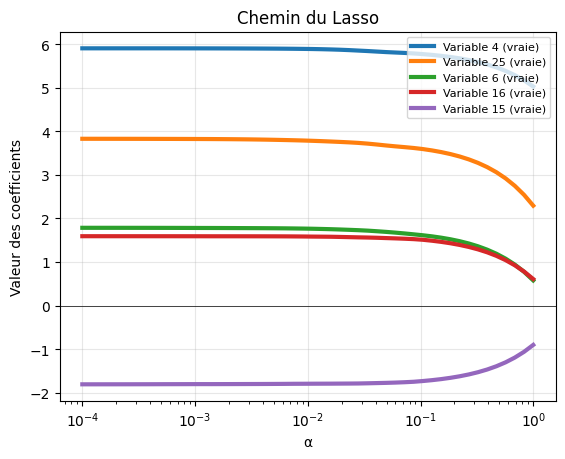

In [19]:
for idx in indices_actifs:
    plt.semilogx(alphas, coefficients[:, idx], linewidth=3, 
                 label=f'Variable {idx} (vraie)')

plt.xlabel('α')
plt.ylabel('Valeur des coefficients')
plt.title('Chemin du Lasso')
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)
plt.savefig('lasso_path.png')


Quelles variables survivent le plus longtemps ?
 

In [ ]:
last_nonzero_alpha = np.zeros(d)
for i in range(d):
    nonzero_indices = np.where(np.abs(coefficients[:, i]) > 1e-6)[0]
    if len(nonzero_indices) > 0:
        last_nonzero_alpha[i] = alphas[nonzero_indices[-1]]

surviving_vars = np.argsort(last_nonzero_alpha)[-10:]
print(f"Top 10 variables qui survivent le plus longtemps:")
for i, var_idx in enumerate(surviving_vars[::-1]):
    print(f"   {i+1}. {surviving_vars[var_idx]}: α_max = {last_nonzero_alpha[var_idx]:.4f}")#


✓ Top 10 variables qui survivent le plus longtemps:
   1. Variable 16: α_max = 1.0000
   2. Variable 25: α_max = 1.0000
   3. Variable 15: α_max = 1.0000
   4. Variable 6: α_max = 1.0000
   5. Variable 4: α_max = 1.0000
   6. Variable 2: α_max = 0.1048
   7. Variable 33: α_max = 0.0869
   8. Variable 0: α_max = 0.0869
   9. Variable 29: α_max = 0.0720
   10. Variable 3: α_max = 0.0494
